# Machine Learning in Crowd Modelling and Simulation - Final Project - Task 4
## Group M:
- Muhammad Waleed Bin Khalid
- Qais Hamarneh
- Yiming Zhang

# Useful Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy
from EDMD import EDMD
from tqdm import tqdm
from Observables import *
%load_ext autoreload
%autoreload 2

## The Limit Cycle

$$
\begin{array}{r}
\dot{y}_{0}=-y_{1}+y_{0}\left(\mu-y_{0}^{2}-y_{1}^{2}\right) \\
\dot{y}_{1}=y_{0}+y_{1}\left(\mu-y_{0}^{2}-y_{1}^{2}\right)
\end{array}
$$

In [2]:
def limit_cycle(t, y):
    """ODE system."""
    mu = 1
    y_dot = np.zeros(2)

    factor = mu - y[0] ** 2 - y[1] ** 2

    y_dot[0] = -y[1] + y[0] * factor
    y_dot[1] = y[0] + y[1] * factor
    return y_dot

In [3]:
t_eval = np.linspace(0, 0.4, 21)

initial_conditions = np.array(
    np.meshgrid(np.linspace(-2, 2, 8), np.linspace(-2, 2, 8))
).T.reshape(-1, 2)
solution_df = pd.DataFrame()

for index, ic in enumerate(initial_conditions):
    solution = solve_ivp(limit_cycle, t_span=(t_eval[0], t_eval[-1]), y0=ic, t_eval=t_eval)
    solution_x = pd.DataFrame(data=solution["y"][:,:-1].T, columns=["x1", "x2"])
    solution_y = pd.DataFrame(data=solution["y"][:,1:].T, columns=["y1", "y2"])
    combined_df = pd.concat([solution_x, solution_y], axis=1)
    combined_df.insert(0, 'ID', index)
    solution_df = pd.concat([solution_df, combined_df])

In [4]:
solution_df

,ID,x1,x2,y1,y2
0,0,-2.000000,-2.000000,-1.735789,-1.806650
1,0,-1.735789,-1.806650,-1.547156,-1.676108
2,0,-1.547156,-1.676108,-1.401879,-1.581086
3,0,-1.401879,-1.581086,-1.286003,-1.510061
4,0,-1.286003,-1.510061,-1.189672,-1.454757
...,...,...,...,...,...
15,63,0.647749,1.227456,0.612206,1.218410
16,63,0.612206,1.218410,0.578201,1.210363
17,63,0.578201,1.210363,0.545490,1.203096
18,63,0.545490,1.203096,0.513883,1.196435


Text(0, 0.5, 'y')

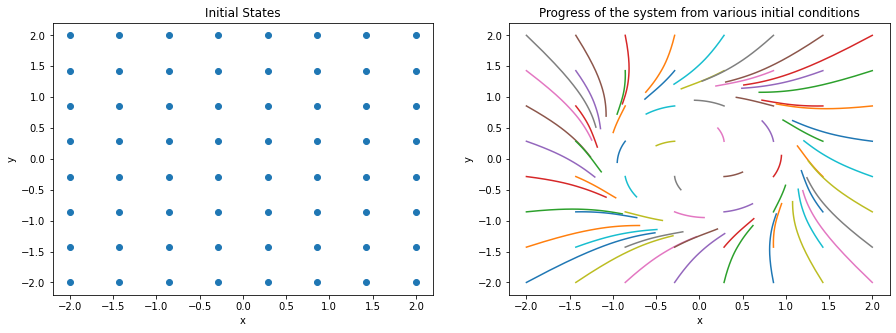

In [5]:
def plot_data(data, ax):
    for id in data['ID'].unique():
        data_id = data[data['ID'] == id]
        plt.plot(data_id['x1'].to_numpy(), data_id['x2'].to_numpy())
    
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].scatter(initial_conditions[:,0], initial_conditions[:,1])
axs[0].set_title('Initial States')
axs[0].set_xlabel('x'); axs[0].set_ylabel('y')
plot_data(solution_df, axs[1])
axs[1].set_title('Progress of the system from various initial conditions')
axs[1].set_xlabel('x'); axs[1].set_ylabel('y')


## Using Identity Observables

In [6]:
identity_observables = Identity() # We will use the Hermite Pair dictionary as observables
identity_observables.fit(solution_df.iloc[:,0:3])

,ID,x1,x2,x1,x2
0,0,-2.000000,-2.000000,-2.000000,-2.000000
1,0,-1.735789,-1.806650,-1.735789,-1.806650
2,0,-1.547156,-1.676108,-1.547156,-1.676108
3,0,-1.401879,-1.581086,-1.401879,-1.581086
4,0,-1.286003,-1.510061,-1.286003,-1.510061
...,...,...,...,...,...
15,63,0.647749,1.227456,0.647749,1.227456
16,63,0.612206,1.218410,0.612206,1.218410
17,63,0.578201,1.210363,0.578201,1.210363
18,63,0.545490,1.203096,0.545490,1.203096


In [7]:
dmd = EDMD(solution_df, 2, identity_observables)
dmd.fit()
A = (dmd.koopman_matrix() - np.eye(2))/ 0.02
print(f"Determinant of governing A matrix is {np.linalg.det(A).real:0.5f}")
print(f"Trace of governing A matrix is {np.trace(A).real:0.5f}")

Determinant of governing A matrix is 2.91592
Trace of governing A matrix is -2.80878


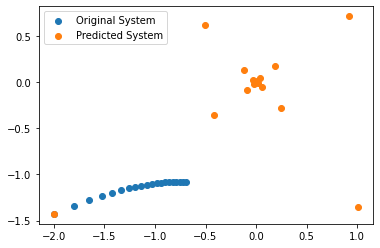

In [8]:
x_actual = solution_df[solution_df['ID'] == 1].iloc[:,:3]
initial_values = x_actual.iloc[0:1,0:3]
x_predict = dmd.predict(initial_values, t_end=20)
fig, axs = plt.subplots(1,1, sharex=True, sharey=True)
axs.scatter(x_actual.iloc[:,1].to_numpy().real, x_actual.iloc[:,2].to_numpy().real, label='Original System')
axs.scatter(x_predict.iloc[:,1].to_numpy().real, x_predict.iloc[:,2].to_numpy(), label='Predicted System')
plt.legend()

## Polynomial Dictionary

In [43]:
polynomials = Polynomials(3)
polynomials.segregate_observables_from_variable(polynomials.fit(solution_df.iloc[:,0:3]))

,ID,x1^0x2^1,x1^0x2^2,x1^0x2^3,x1^1x2^0,x1^1x2^1,x1^1x2^2,x1^2x2^0,x1^2x2^1,x1^3x2^0
0,0,-2.000000,4.000000,-8.000000,-2.000000,4.000000,-8.000000,4.000000,-8.000000,-8.000000
1,0,-1.806650,3.263986,-5.896881,-1.735789,3.135963,-5.665589,3.012962,-5.443370,-5.229866
2,0,-1.676108,2.809339,-4.708757,-1.547156,2.593201,-4.346485,2.393691,-4.012086,-3.703414
3,0,-1.581086,2.499832,-3.952449,-1.401879,2.216491,-3.504462,1.965264,-3.107252,-2.755063
4,0,-1.510061,2.280283,-3.443365,-1.286003,1.941942,-2.932450,1.653802,-2.497342,-2.126794
...,...,...,...,...,...,...,...,...,...,...
15,63,1.227456,1.506648,1.849343,0.647749,0.795083,0.975929,0.419578,0.515014,0.271781
16,63,1.218410,1.484522,1.808757,0.612206,0.745917,0.908833,0.374796,0.456655,0.229452
17,63,1.210363,1.464978,1.773154,0.578201,0.699833,0.847052,0.334317,0.404644,0.193302
18,63,1.203096,1.447439,1.741407,0.545490,0.656277,0.789563,0.297559,0.357992,0.162316


In [ ]:
dmd = EDMD(solution_df, 2, identity_observables)
dmd.fit()
A = (dmd.koopman_matrix() - np.eye(2))/ 0.02
print(f"Determinant of governing A matrix is {np.linalg.det(A).real:0.5f}")
print(f"Trace of governing A matrix is {np.trace(A).real:0.5f}")